In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Устанавливаем параметры холста для всех графиков matplotlib
sns.set(palette='Set2', font_scale=1.2)

Больше материалов о библиотеках можно узнать в туториалах [здесь](https://mipt-stats.gitlab.io/courses/python.html)

# Временные ряды. 
## Работа с данными

В этом ноутбуке мы будем работать с данными о продажах тороговой сети [Walmart](https://en.wikipedia.org/wiki/Walmart), крупнейшей в мире сети оптовой и розничной торговли. Данные были предствлены на [соревновании в Kaggle](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview) аж 7 лет назад, и тогда считались одним из самых крупных наборов открытых данных. Само соревнование проводилось среди соискателей работы в Walmart (видимо, искали data science специалистов). Цель соревнования состояла в том, чтобы спрогнозировать продажи для каждого отдела (department) в каждом из представленных магазинов (store).

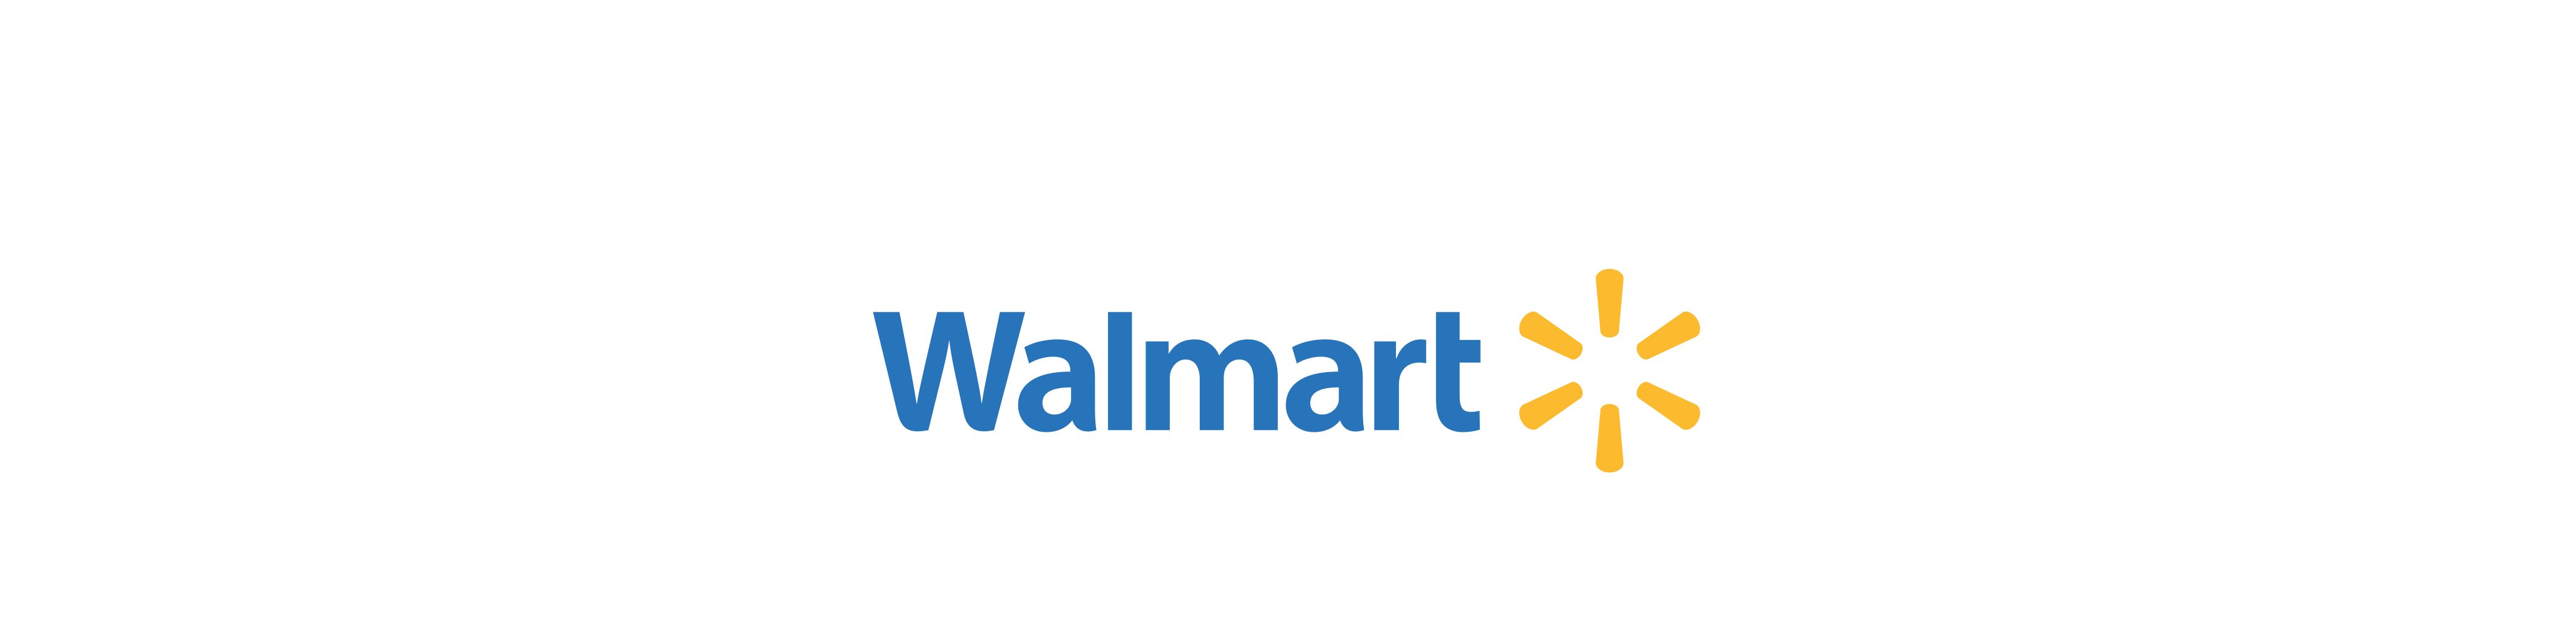

Скачать данные можно во [вкладке Data](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data) на странице соревнования.

Всего имеется 4 файла с данными: `stores.csv`, `train.csv`, `test.csv`, `features.csv`. В этом занятии мы будем использовать все кроме теста. `stores.csv` содержит информацию о магазинах, `features.csv` &mdash; дополнительную информацию о магазинах, отделах и региональной активности, в регионе магазина, `train.csv` &mdash; информацию о продажах.

Данные содержат разные колонки: `Store` &mdash; номер магазина, `Dept` &mdash; номер отдела, `Date` &mdash; дата, `Type` &mdash; тип магазина, `Weekly_Sales` &mdash; продажи за неделю в данном магазине в данном отделе, `IsHoliday` &mdash; явялйется ли неделя выходной, праздничной, `Temperature` &mdash; средняя температура в регионе, `Fuel_Price` &mdash; цена бензина в регионе, `Markdown1-5` &mdash; анонимизированная информация о скидках, `CPI` &mdash; индекс потребительских цен (consumer price index), `Unemployment` &mdash; уровень безработицы в регионе.

### Как считывать и сохранять временные данные с помощью pandas

#### read_csv
Попробуем самым обычным образом считать файл.

Так как в `train.csv` содержатся данные о продажах, то назовем DataFrame `sales`.

In [2]:
sales = pd.read_csv("./Walmart/train.csv")
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


#### info
Выведем основную информацию о продажах с помощью функции `info`.

In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


#### to_datetime
Мы видим, что все типы колонок опредились pandas правильно кроме `Date`. Нам бы хотелось, чтобы даты были специальном формате `datetime`. Для этого воспользуемся функцией `to_datetime`.

In [4]:
sales.Date = pd.to_datetime(sales.Date)
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


Теперь даты стали правильного формата.

Также есть способ распознать даты с самого начала при загрузке DataFrame. Для этого нужно указать колнки с датами в аргументе `parse_dates`.

In [5]:
sales = pd.read_csv("./Walmart/train.csv", parse_dates=['Date'])
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


#### Форматы дат 
Предположим, что нас попросили кому-нибудь, например русскому партнеру компании, передать полученные данные со стандартным для России форматом дат `DD.MM.YYYY`. Для этого укажем заданный формат в аргументе `date_format` в функции `to_csv`.

> Обратим внимание на то, **как задается дата**. Чтобы перевести дату в строку используется функция `	
strftime`. Она поддерживает специальный формат, в котором каждая деректива, будь то год `Y`, месяц `m`, день `d`, час `H`, минута `M`, секунда `S` и т.д., передается через `%`. Подробнее про формат записи дат можно посмотреть по [ссылке](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior).

In [6]:
sales.to_csv("./Walmart/sales.csv", date_format="%d.%m.%Y", index=None)

Посмотрим что получилось в файле.

In [7]:
with open("./Walmart/sales.csv", "r") as file:
    n = 0
    for line in file.readlines():
        if n == 5:
            break
        print(line)
        n += 1

Store,Dept,Date,Weekly_Sales,IsHoliday

1,1,05.02.2010,24924.5,False

1,1,12.02.2010,46039.49,True

1,1,19.02.2010,41595.55,False

1,1,26.02.2010,19403.54,False



Видим, что даты записались в нужном формате.

Теперь попробуем их прочитать, укажем нужную колонку для парсинга дат.

In [8]:
sales = pd.read_csv("./Walmart/sales.csv", parse_dates=['Date'])
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


Даты распознались, но неправильно. Местами день и месяц перепутаны. Для того, чтобы данные считались правильно, установим аргумент `dayfirst` равным `True` в функции `read_csv`.

In [9]:
sales = pd.read_csv("./Walmart/sales.csv", parse_dates=['Date'], dayfirst=True)
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Теперь даты считались правильно. В более сложных случаях, можно написать свою функцию для распознавания дат и поставить ее как аргумент `date_parser`. Для нашего примера она будет выглядеть так.

In [10]:
sales = pd.read_csv("./Walmart/sales.csv", parse_dates=['Date'], 
                    date_parser=lambda s: datetime.strptime(s, "%d.%m.%Y"))
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


### Работа с датами в pandas

Считаем таблицу с различными дополнительми признаками.

In [11]:
features = pd.read_csv("./Walmart/features.csv", parse_dates=['Date'])
features.head(20)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
5,1,2010-03-12,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False
6,1,2010-03-19,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False
7,1,2010-03-26,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False
8,1,2010-04-02,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False
9,1,2010-04-09,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False


Выделим первую дату из данных.

In [12]:
date = features.Date[0]
date

Timestamp('2010-02-05 00:00:00')

#### date, day, month, year
Выделим дату, а также день, месяц и год.

In [13]:
print(f"Дата: {date.date()}\n\n"
      f"День: {date.day}\n"
      f"Месяц: {date.month} ({date.month_name()})\n"
      f"Год: {date.year}\n")

Дата: 2010-02-05

День: 5
Месяц: 2 (February)
Год: 2010



#### day_of_week, day_name, day_of_year, weekofyear
Также можем рассмотреть такие характеристики как день недели, день в году, неделя в году.

In [14]:
print(f"День недели: {date.day_of_week} ({date.day_name()})\n"
      f"День года: {date.day_of_year}\n"
      f"Неделя в году: {date.weekofyear}\n")

День недели: 4 (Friday)
День года: 36
Неделя в году: 5



Хоть время и не задано в данных, оно по дефлоту становится равным 0.

In [15]:
print(f"Часы: {date.hour}\n"
      f"Минуты: {date.minute}\n"
      f"Секунды: {date.second}\n")

Часы: 0
Минуты: 0
Секунды: 0



Мы можем добавить свое время, используя класс `Timedelta`.
> Как задавать нужный времнной интервал смотри [тут](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timedelta.html)

In [16]:
date += pd.Timedelta('15hour 3min 20sec')
date

Timestamp('2010-02-05 15:03:20')

Теперь проверим время.

In [17]:
print(f"Часы: {date.hour}\n"
      f"Минуты: {date.minute}\n"
      f"Секунды: {date.second}\n")

Часы: 15
Минуты: 3
Секунды: 20



> Дата/dремя задается в `pandas`  с помощью класса `Timestamp`. Больше объектов и методов это класса можно найти [здесь](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html).

Теперь будем работать с ценами на бензин.

#### resample, set_index

Предположим, нас попросили узнать среднюю цену на бензин за 4 недели по всем магазинам. Это можно было бы сделать пройдясь циклом по всем датам, объединим вручную их по 4 недели и посчитав среднее. Но можно все сделать гораздо проще &mdash; с помощью функции `resample`.

* Установим дату как индекс. 
* Выберем колонку `Fuel_Price`. 
* С помощью `resample` объединим даты по 4 недели. 
* Посчитаем среднее.

In [18]:
fuel_prices = features.set_index('Date').Fuel_Price.resample('4w-FRI', origin='start').mean()
fuel_prices.head()

Date
2010-02-05    2.717844
2010-03-05    2.695306
2010-04-02    2.810739
2010-04-30    2.878839
2010-05-28    2.917350
Freq: 4W-FRI, Name: Fuel_Price, dtype: float64

Отобразим полученные данные.

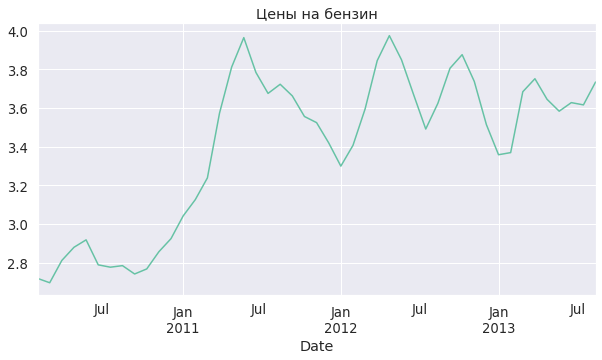

In [19]:
fuel_prices.plot(title="Цены на бензин", figsize=(10, 5));

#### shift, diff, pct_change

А потом попросили предоставить процентное изменение цены во времени.

Попробуем выполнить задачу по следующему алгоритму. 
* Получить данные со сдвигом по времени. 
* Посчитать разницу между текущими и данными в будущем.
* Эту разницу подедить на предыдущее значение.
* Перевести результат в проценты.

In [20]:
shifted_fuel_prices = fuel_prices.shift(periods=1)
shifted_fuel_prices.head()

Date
2010-02-05         NaN
2010-03-05    2.717844
2010-04-02    2.695306
2010-04-30    2.810739
2010-05-28    2.878839
Freq: 4W-FRI, Name: Fuel_Price, dtype: float64

In [21]:
pct_change_1 = (fuel_prices - shifted_fuel_prices) / shifted_fuel_prices * 100
pct_change_1.head()

Date
2010-02-05         NaN
2010-03-05   -0.829293
2010-04-02    4.282755
2010-04-30    2.422850
2010-05-28    1.337731
Freq: 4W-FRI, Name: Fuel_Price, dtype: float64

Вместо `shift` и отнимания, можно использовать `diff`.

In [22]:
pct_change_2 = fuel_prices.diff() / shifted_fuel_prices * 100
pct_change_2.head()

Date
2010-02-05         NaN
2010-03-05   -0.829293
2010-04-02    4.282755
2010-04-30    2.422850
2010-05-28    1.337731
Freq: 4W-FRI, Name: Fuel_Price, dtype: float64

А можно вместо всех этих операций просто использовать `pct_change`.

In [23]:
pct_change_3 = fuel_prices.pct_change() * 100
pct_change_3.head()

Date
2010-02-05         NaN
2010-03-05   -0.829293
2010-04-02    4.282755
2010-04-30    2.422850
2010-05-28    1.337731
Freq: 4W-FRI, Name: Fuel_Price, dtype: float64

Наконец отобразим график процентных изменений средней цены нефти.

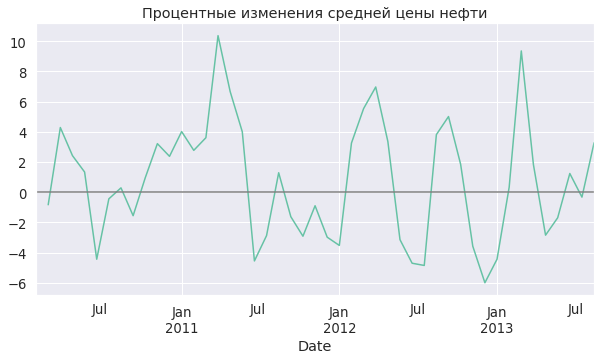

In [24]:
pct_change_3.plot(figsize=(10, 5), title='Процентные изменения средней цены нефти')
plt.axhline(c='gray');

Перейдем к данным из колонки `IsHoliday`. Данные ограничены июлем 2013 года. Праздничные недели скорее всего циклины по годам. На основе этого предположения, посчитаем какие недели были праздничными до конца 2013 года.

Для начала удалим все повторяющиеся пары неделя/праздник.

#### drop_duplicates

In [25]:
holidays = features[['Date', 'IsHoliday']].drop_duplicates()

Удостоверимся, что не бывает недель с неоднозначным состоянием праздничная/не праздничная.

In [26]:
np.unique(holidays['Date'], return_counts=True)[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

Далее будем работать с данными как с `Series`. В качестве идекса устновим дату.

In [27]:
holidays = holidays.set_index('Date').squeeze()
holidays.head()

Date
2010-02-05    False
2010-02-12     True
2010-02-19    False
2010-02-26    False
2010-03-05    False
Name: IsHoliday, dtype: bool

#### date_range
Вычислим даты для каждой недели вплоть до конца года день, когда будут записываться данные. В этом нам поможет функция `date_range`.

In [28]:
future_dates = pd.date_range(
    start=holidays.index[-1], 
    end=pd.to_datetime('31.12.2013', dayfirst=True),
    freq='7D'
)[1:]
future_dates

DatetimeIndex(['2013-08-02', '2013-08-09', '2013-08-16', '2013-08-23',
               '2013-08-30', '2013-09-06', '2013-09-13', '2013-09-20',
               '2013-09-27', '2013-10-04', '2013-10-11', '2013-10-18',
               '2013-10-25', '2013-11-01', '2013-11-08', '2013-11-15',
               '2013-11-22', '2013-11-29', '2013-12-06', '2013-12-13',
               '2013-12-20', '2013-12-27'],
              dtype='datetime64[ns]', freq='7D')

Создадим `Series` с новыми датами. В качестве значений мы возьмем те же значения, что были год назад. Для того, чтобы вычислить нужные даты предыдущего года, от новых отнимем 364 дня. Потому что 364 делится на 7. Чтобы обозначить дни будем использовать класс `Timedelta`.

In [29]:
future_holidays = pd.Series(
    data=holidays.loc[future_dates - pd.Timedelta('364D')].values, 
    index=future_dates
)
future_holidays

2013-08-02    False
2013-08-09    False
2013-08-16    False
2013-08-23    False
2013-08-30    False
2013-09-06     True
2013-09-13    False
2013-09-20    False
2013-09-27    False
2013-10-04    False
2013-10-11    False
2013-10-18    False
2013-10-25    False
2013-11-01    False
2013-11-08    False
2013-11-15    False
2013-11-22     True
2013-11-29    False
2013-12-06    False
2013-12-13    False
2013-12-20    False
2013-12-27     True
Freq: 7D, dtype: bool

#### append, concat
Теперь объединим полученные даты с прошлыми. Таким образом у нас будут данные о том, какая неделя праздничная вплоть до конца 2013 года.

In [30]:
new_holidays = holidays.append(future_holidays)
new_holidays

2010-02-05    False
2010-02-12     True
2010-02-19    False
2010-02-26    False
2010-03-05    False
              ...  
2013-11-29    False
2013-12-06    False
2013-12-13    False
2013-12-20    False
2013-12-27     True
Length: 204, dtype: bool

То же самое мы можем сделать с помощью concat.

In [31]:
new_holidays = pd.concat([holidays, future_holidays])
new_holidays

2010-02-05    False
2010-02-12     True
2010-02-19    False
2010-02-26    False
2010-03-05    False
              ...  
2013-11-29    False
2013-12-06    False
2013-12-13    False
2013-12-20    False
2013-12-27     True
Length: 204, dtype: bool

## Декомпозиция временных рядов

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from pylab import rcParams

Декомпозиция - метод разложения временного ряда на три компоненты: \
**Тренд** - плавное долгосрочное изменение временного ряда. \
**Сезонность** - циклические изменения временного ряда с постоянным периодом сезонности s. \
**Ошибка** - непрогнозируемая случайная компонента ряда.

Декомпозиция бывает 2 типов: \
аддитивная: $y_t = T_t+S_t+R_t$ \
мультипликативная: $y_t = T_t\cdot S_t\cdot R_t$

### Данные Walmart
Применим методы декомпозиции временных рядов к суммарным данным о продажах.

In [47]:
sales_data = sales.groupby('Date').sum()['Weekly_Sales']
sales_data

Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
                 ...     
2012-09-28    43734899.40
2012-10-05    47566639.31
2012-10-12    46128514.25
2012-10-19    45122410.57
2012-10-26    45544116.29
Name: Weekly_Sales, Length: 143, dtype: float64

#### Декомпозиция на основе скользящего среднего

Пусть $s$ - известный заранее период сезонности.

**Тренд** в момент времени t: $T_t = \frac{1}{s}\sum_{i=t-s/2}^{t+s/2}Y_i$

**Сезонность** - усреднение наблюдений для каждого сезона после удаления тренда. По шагам:
* $y_t' = y_t - T_t$
* Формируется s подгрупп $G_i = \{Y_i, Y_{i+s}, \dots, Y_{i+ks}\}$
* $S_i = \overline{G_{i}}$

**Ошибка**: $R_t=y_t-T_t-S_{t  \% s}$

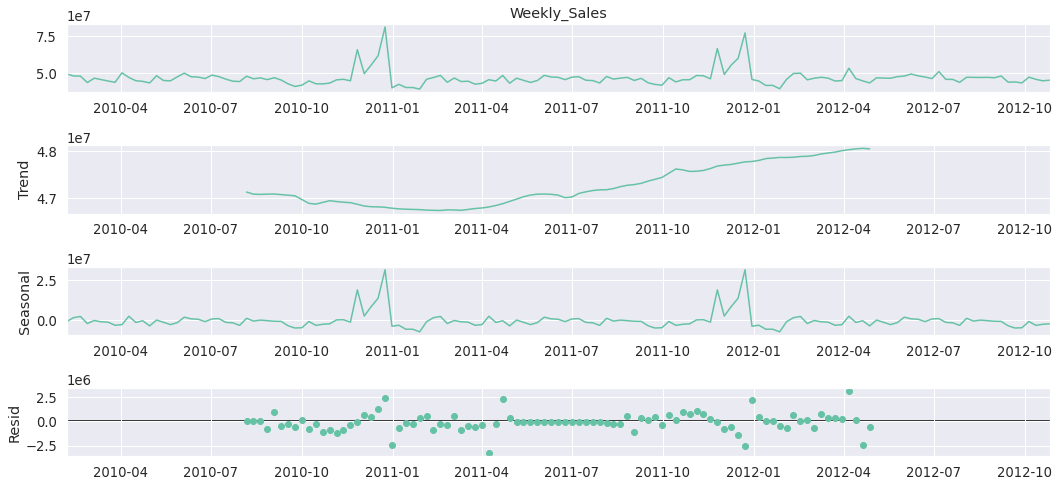

In [63]:
rcParams['figure.figsize'] = 15, 7
simple_result = seasonal_decompose(sales_data, model='additive', period=52)
simple_result.plot();

Наблюдаем негладкий тренд и очень странные остатки. Сезонность практически совпадает с исходным графиком.

#### STL-декомпозиция

[STL](https://www.wessa.net/download/stl.pdf) - Seasonal-Trend decomposition using LOESS (locally estimated scatterplot smoothing).

LOESS - взвешенная линейная регрессия, где вес - это расстояние от текущего времени $t$ до времени $t'$, на которых обучается модель.

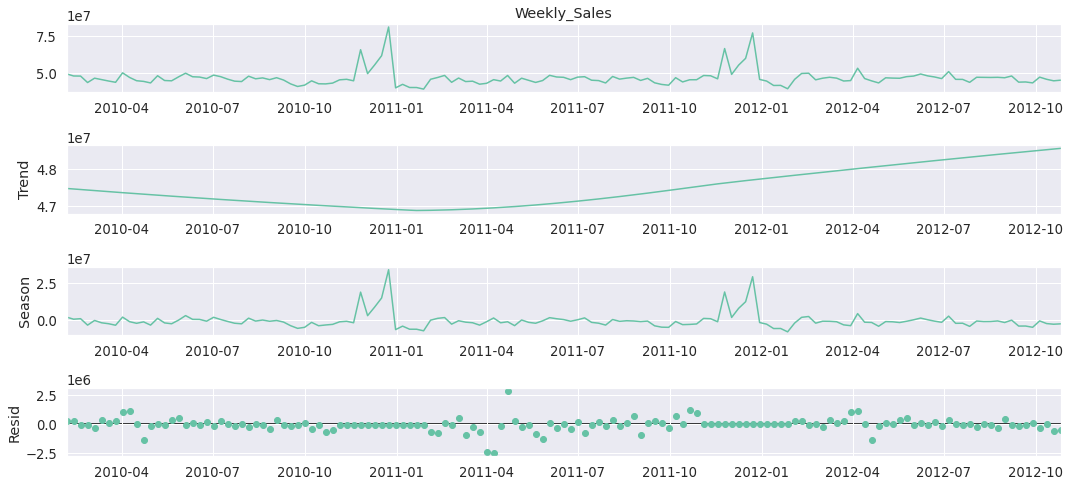

In [59]:
result = STL(sales_data, period=52).fit()
result.plot();

Тренд стал гладким. Остатки прняли чуть более нормальный вид.

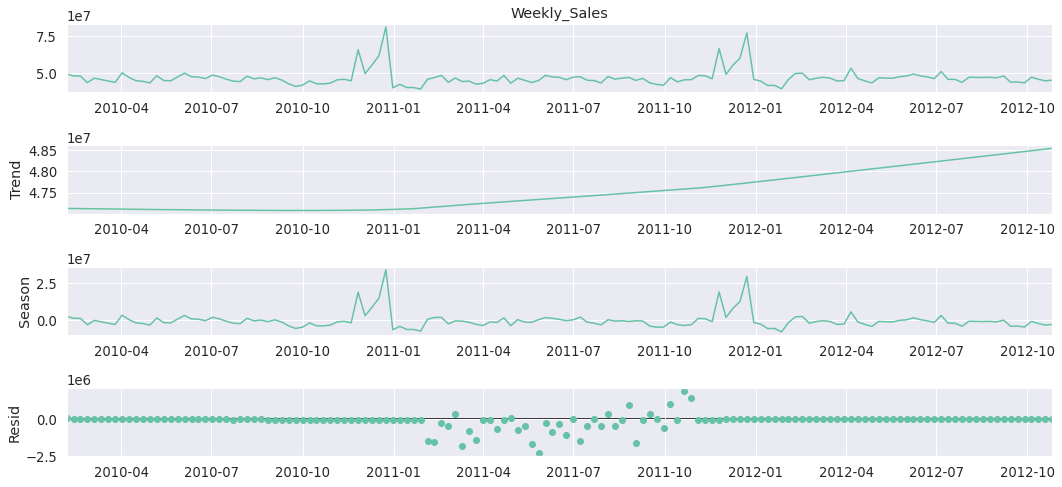

In [50]:
robust_result = STL(sales_data, period=52, robust=True).fit()
robust_result.plot();

Сильно лучше не стало.

В данном примере есть проблема с сезонностью &mdash; она абсолютно не информативна. Давайте попробуем сделать то же самое на других данных. Загрузим датасет про ежемесячные продажи антидиабетических препаратов в Австралии с 1992 по 2008 год.

### Данные об антиадиабетических препаратах

In [51]:
title = 'Monthly anti-diabetic drug sales in Australia from 1992 to 2008' 
antidiab = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates=['date'])
antidiab.index = antidiab['date']
antidiab = antidiab.drop(columns=['date']).squeeze()

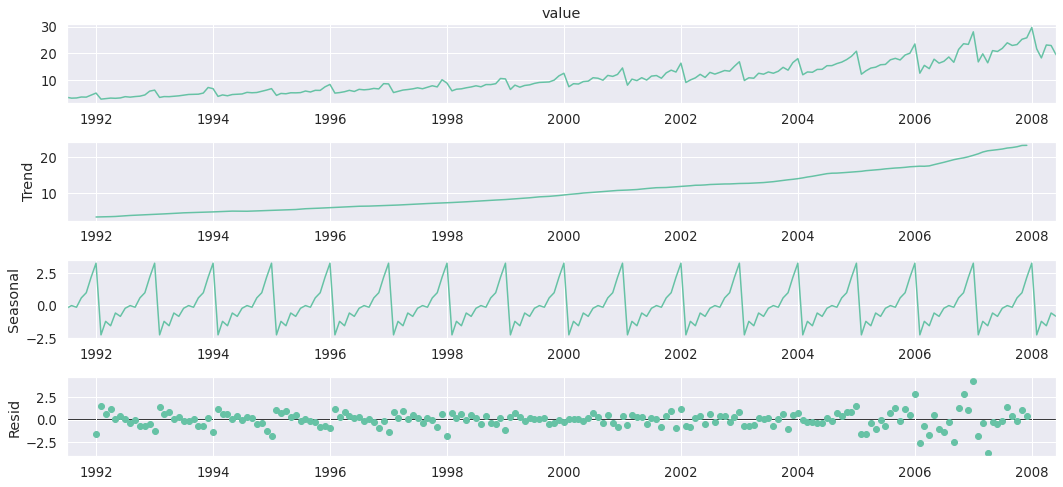

In [52]:
simple_result = seasonal_decompose(antidiab, model='additive', period=12)
simple_result.plot();

Наблюдаем хорошую сезонность, но остатки не похожи на нормальные.

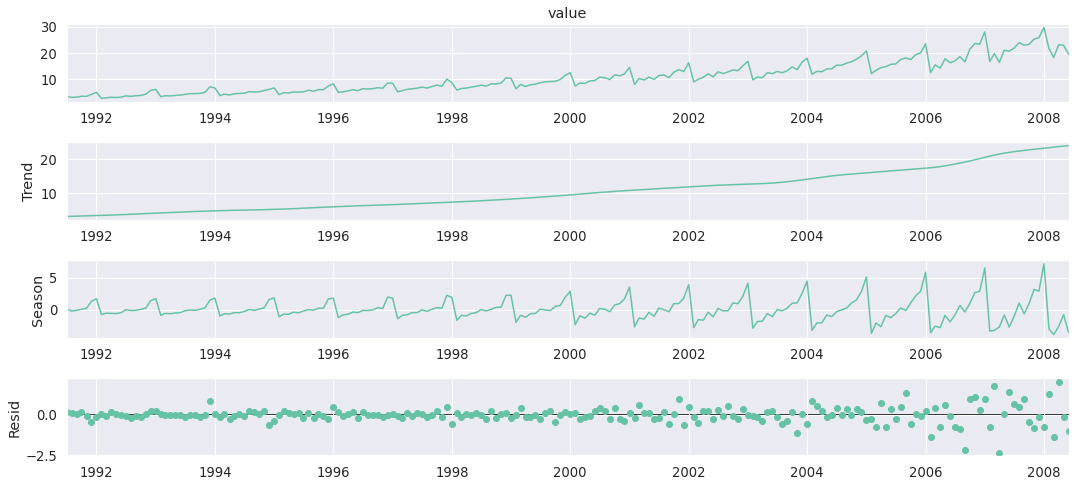

In [53]:
result = STL(antidiab, period=12).fit()
result.plot();

В остатках исчезла периодичность, но зато появилась динамика.

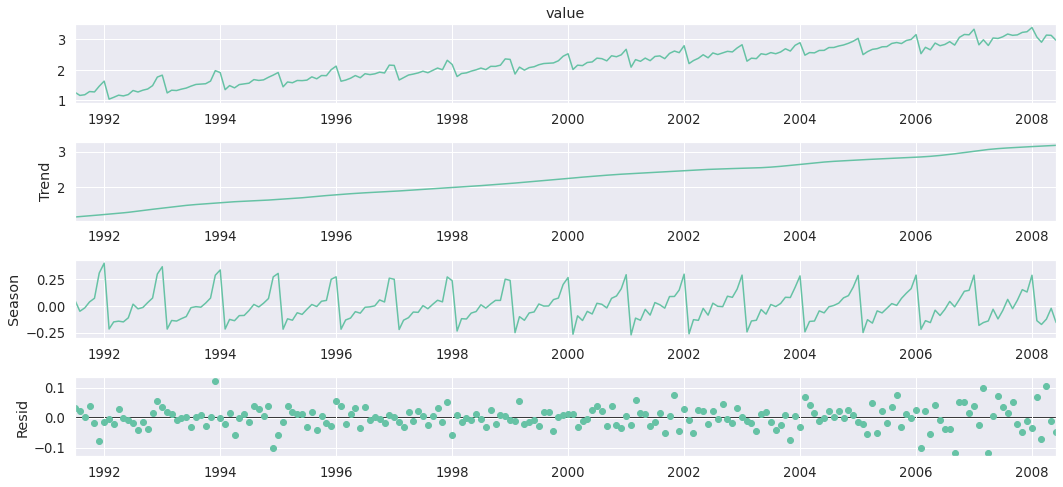

In [54]:
log_antidiab = pd.Series(np.log(antidiab), index=antidiab.index)
result = STL(log_antidiab, period=12).fit()
result.plot();

Сезонность и остатки стали выглядеть гораздо лучше.